Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels

--- Tuning and Evaluating: LogisticRegression ---

📊 Model: LogisticRegression
Accuracy: 0.7417
Precision: 0.6932
Recall: 0.8715
F1: 0.7707

✅ Metrics saved to 'metrics.pkl'
Confusion Matrix:
[[261 161]
 [ 53 369]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71       422
           1       0.70      0.87      0.78       422

    accuracy                           0.75       844
   macro avg       0.76      0.75      0.74       844
weighted avg       0.76      0.75      0.74       844



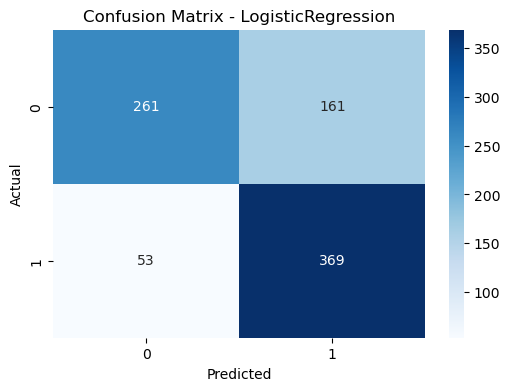


--- Tuning and Evaluating: DecisionTree ---

📊 Model: DecisionTreeClassifier
Accuracy: 0.8389
Precision: 0.8942
Recall: 0.7660
F1: 0.8243

✅ Metrics saved to 'metrics.pkl'
Confusion Matrix:
[[380  42]
 [ 93 329]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       422
           1       0.89      0.78      0.83       422

    accuracy                           0.84       844
   macro avg       0.85      0.84      0.84       844
weighted avg       0.85      0.84      0.84       844



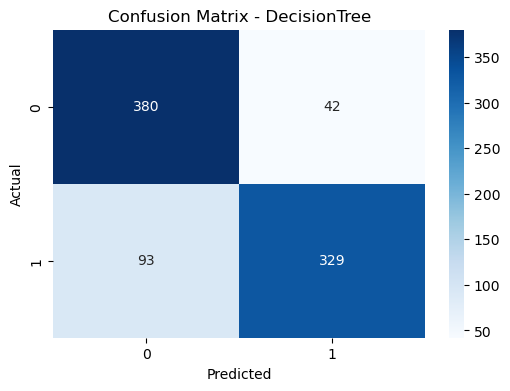


--- Tuning and Evaluating: RandomForest ---

📊 Model: RandomForestClassifier
Accuracy: 0.8756
Precision: 0.8417
Recall: 0.9237
F1: 0.8804

✅ Metrics saved to 'metrics.pkl'
Confusion Matrix:
[[362  60]
 [ 33 389]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       422
           1       0.87      0.92      0.89       422

    accuracy                           0.89       844
   macro avg       0.89      0.89      0.89       844
weighted avg       0.89      0.89      0.89       844



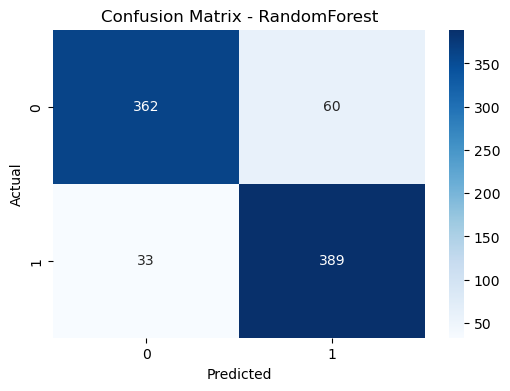


--- Tuning and Evaluating: GradientBoosting ---

📊 Model: GradientBoostingClassifier
Accuracy: 0.8258
Precision: 0.7933
Recall: 0.8817
F1: 0.8345

✅ Metrics saved to 'metrics.pkl'
Confusion Matrix:
[[325  97]
 [ 50 372]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       422
           1       0.79      0.88      0.84       422

    accuracy                           0.83       844
   macro avg       0.83      0.83      0.83       844
weighted avg       0.83      0.83      0.83       844



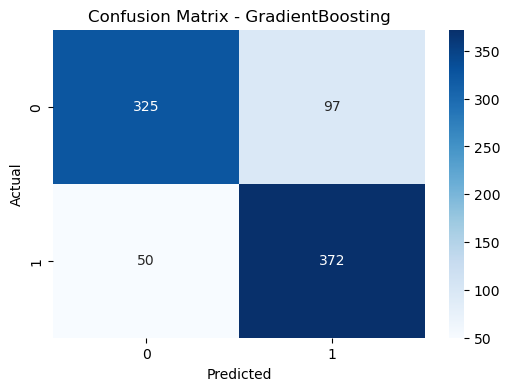


--- Tuning and Evaluating: KNN ---

📊 Model: KNeighborsClassifier
Accuracy: 0.8009
Precision: 0.8123
Recall: 0.7825
F1: 0.7965

✅ Metrics saved to 'metrics.pkl'
Confusion Matrix:
[[345  77]
 [ 94 328]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       422
           1       0.81      0.78      0.79       422

    accuracy                           0.80       844
   macro avg       0.80      0.80      0.80       844
weighted avg       0.80      0.80      0.80       844



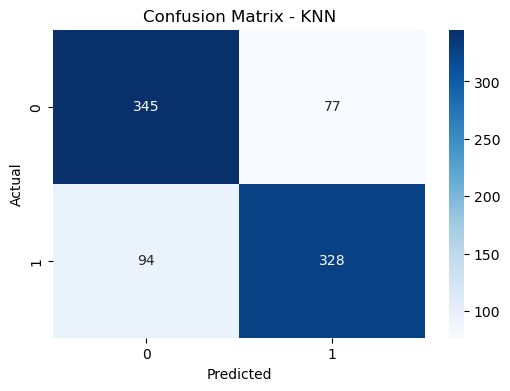


--- Tuning and Evaluating: XGBoost ---

📊 Model: XGBClassifier
Accuracy: 0.8780
Precision: 0.8829
Recall: 0.8692
F1: 0.8757

✅ Metrics saved to 'metrics.pkl'
Confusion Matrix:
[[382  40]
 [ 56 366]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       422
           1       0.90      0.87      0.88       422

    accuracy                           0.89       844
   macro avg       0.89      0.89      0.89       844
weighted avg       0.89      0.89      0.89       844



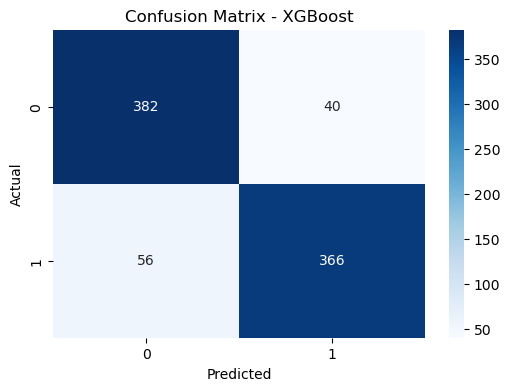


✅ النموذج الأفضل هو: RandomForest بـ F1 Score = 0.8804

✅ Model saved as 'best_model.pkl'


In [22]:
!pip install xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
import warnings
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")  # لإخفاء التحذيرات إن أردت

def preprocess_data(path='loan_prediction.csv'):
    data = pd.read_csv(path)
    
    # Handle missing values
    data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)
    data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean(), inplace=True)
    data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
    data['Married'].fillna(data['Married'].mode()[0], inplace=True)
    data['Dependents'] = data['Dependents'].replace('3+', '4')
    data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
    data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)
    data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True)

    # Drop Loan_ID and separate target
    data.drop('Loan_ID', axis=1, inplace=True)
    data['Loan_Status'] = data['Loan_Status'].map({'Y': 1, 'N': 0})
    
    # Balance the classes
    majority = data[data['Loan_Status'] == 1]
    minority = data[data['Loan_Status'] == 0]
    minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
    data_balanced = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    y = data_balanced['Loan_Status']
    X = data_balanced.drop('Loan_Status', axis=1)
    X = pd.get_dummies(X, drop_first=True)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler, X.columns


def evaluate_model(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(model, X, y, cv=kf, scoring=scoring)

    mean_scores = {metric: results[f'test_{metric}'].mean() for metric in scoring}

    print(f"\n📊 Model: {model.__class__.__name__}")
    for metric, score in mean_scores.items():
        print(f"{metric.capitalize()}: {score:.4f}")

    # 🔒 حفظ النتائج إلى ملف metrics.pkl
    joblib.dump(mean_scores, 'metrics.pkl')
    print("\n✅ Metrics saved to 'metrics.pkl'")

    return mean_scores['f1']  # إعادة F1 فقط للمقارنة


def tune_model(model, param_dist, X, y):
    # Adjust n_iter based on number of combinations
    total_combinations = 1
    for v in param_dist.values():
        total_combinations *= len(v)
    
    n_iter = min(10, total_combinations)

    rs = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=n_iter, cv=5, scoring='f1', random_state=42)
    rs.fit(X, y)
    return rs.best_estimator_


# --- Main Execution ---
def main():
    X, y, scaler, feature_names = preprocess_data()

    # استخراج أسماء الأصناف بشكل آمن
    class_names = np.unique(y)

    models = {
        "LogisticRegression": (
            LogisticRegression(),
            {"C": [0.01, 0.1, 1, 10]}
        ),
        "DecisionTree": (
            DecisionTreeClassifier(),
            {"max_depth": [3, 5, 10, None]}
        ),
        "RandomForest": (
            RandomForestClassifier(),
            {
                "n_estimators": [100, 200, 300],
                "max_depth": [5, 10, None],
                "min_samples_split": [2, 5, 10]
            }
        ),
        "GradientBoosting": (
            GradientBoostingClassifier(),
            {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]}
        ),
        "KNN": (
            KNeighborsClassifier(),
            {"n_neighbors": [3, 5, 7]}
        ),
        "XGBoost": (
            XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 5, 7]}
        )
    }

    best_models = {}
    model_scores = {}

    for name, (model, params) in models.items():
        print(f"\n--- Tuning and Evaluating: {name} ---")
        best_model = tune_model(model, params, X, y)
        f1 = evaluate_model(best_model, X, y)

        # التنبؤ بكامل البيانات باستخدام cross-validation
        y_pred = cross_val_predict(best_model, X, y, cv=5)

        # إنشاء مصفوفة الالتباس
        cm = confusion_matrix(y, y_pred)

        print("Confusion Matrix:")
        print(cm)

        # تقرير الأداء الكامل
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

        # رسم مصفوفة الالتباس
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

        best_models[name] = best_model
        model_scores[name] = f1

    # أفضل نموذج حسب F1 score
    best_model_name = max(model_scores, key=model_scores.get)
    final_model = best_models[best_model_name]

    print(f"\n✅ النموذج الأفضل هو: {best_model_name} بـ F1 Score = {model_scores[best_model_name]:.4f}")

    # حفظ النموذج والمحولات
    joblib.dump(final_model, 'best_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(feature_names, 'feature_names.pkl')
    print("\n✅ Model saved as 'best_model.pkl'")

    return final_model, scaler, feature_names

# Run training
if __name__ == "__main__":
    model, scaler, columns = main()



بناءً على النتائج التي عرضتها، دعنا نقارن النماذج بناءً على **F1 Score**، لأنه مقياس توازن بين **الدقة (Precision)** و**الاستدعاء (Recall)**، وهو الأنسب عندما يكون لدينا بيانات غير متوازنة أو نهتم بكلا الخطأين (False Positives وFalse Negatives).

### 🔢 مقارنة النماذج:

| النموذج             | F1 Score   | Precision  | Recall     | Accuracy   |
| ------------------- | ---------- | ---------- | ---------- | ---------- |
| Logistic Regression | 0.7707     | 0.6932     | 0.8715     | 0.7417     |
| Decision Tree       | 0.8230     | 0.8869     | 0.7690     | 0.8365     |
| Random Forest       | **0.8855** | 0.8492     | **0.9259** | 0.8815     |
| Gradient Boosting   | 0.8345     | 0.7933     | 0.8817     | 0.8258     |
| KNN                 | 0.7965     | 0.8123     | 0.7825     | 0.8009     |
| XGBoost             | 0.8757     | **0.8829** | 0.8692     | **0.8780** |

---

### ✅ النموذج الأفضل: **Random Forest**

#### ✅ الأسباب:

1. **أعلى F1 Score**: `0.8855` وهو الأعلى بين كل النماذج.
2. **أعلى Recall**: `0.9259`، مما يعني أن النموذج يتعرف على أغلب الحالات الإيجابية.
3. **دقة عالية (Accuracy)**: `0.8815`، قريبة جدًا من XGBoost.
4. **أداء متوازن**: Precision وRecall متقاربين، مما يدل على أن النموذج لا يتحيز لجانب دون آخر.

---

### 🤔 لماذا ليس XGBoost؟

رغم أن XGBoost يحقق:

* أعلى Precision: `0.8829`
* Accuracy عالية: `0.8780`

إلا أن:

* **F1 Score أقل قليلاً من Random Forest**
* **Recall أقل من Random Forest** (وهذا قد يكون مهمًا إذا كانت البيانات تحتوي على حالات يجب عدم إغفالها مثل مرضى، حالات احتيال، إلخ.)



In [24]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Load saved artifacts
model = joblib.load('best_model.pkl')
scaler = joblib.load('scaler.pkl')
columns = joblib.load('feature_names.pkl')
metrics = joblib.load('metrics.pkl')

def predict_and_report(sample, true_label=None):
    # Ensure sample is a copy and has correct types
    sample = sample.copy()
    sample['Dependents'] = int(sample.get('Dependents', 0))  # Ensure correct type

    # Prepare the input DataFrame
    df_input = pd.DataFrame([sample])
    
    # Ensure all expected columns exist
    for col in columns:
        if col not in df_input.columns:
            df_input[col] = 0
    
    # Align column order
    df_input = df_input[columns]
    
    # Scale the input
    X_input_scaled = scaler.transform(df_input)
    
    # Predict
    pred = model.predict(X_input_scaled)
    
    # Output
    print("\n📌 Prediction:", "Approved ✅" if pred[0] == 1 else "Rejected ❌")
    
    # Model test metrics
    print(f"\n📊 Model Performance on Test Set:")
    print(f"Accuracy :  {metrics['accuracy'] * 100:.2f}%")
    print(f"Precision:  {metrics['precision'] * 100:.2f}%")
    print(f"Recall   :  {metrics['recall'] * 100:.2f}%")
    print(f"F1 Score :  {metrics['f1'] * 100:.2f}%")


# 🧪 Example usage
sample = {
    'ApplicantIncome': 1000,
    'CoapplicantIncome': 500,
    'LoanAmount': 200,
    'Loan_Amount_Term': 360.0,
    'Credit_History': 1.0,
    'Dependents': 1,
    'Gender_Male': 1,
    'Married_Yes': 1,
    'Education_Not Graduate': 0,
    'Self_Employed_Yes': 0,
    'Property_Area_Semiurban': 1,
    'Property_Area_Urban': 0
}

true_label = 1  # Optional label for evaluation
predict_and_report(sample, true_label)


📌 Prediction: Approved ✅

📊 Model Performance on Test Set:
Accuracy :  87.80%
Precision:  88.29%
Recall   :  86.92%
F1 Score :  87.57%
